In [1]:
#  Imports ---
import os
import glob
import shutil
import random
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torch

import PIL


# Data Loading and Cleaning

In [2]:
# . Data Loading and Cleaning ---
# Define the main output directory
output_dir = "/kaggle/working/tomatodata"

# --- FIX: Ensure a clean start ---
# If the output directory already exists from a previous run, remove it completely
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Now, create a fresh, empty output directory
os.makedirs(output_dir)

# Find all tomato-related folders inside the dataset
source_dir = "/kaggle/input/plantdisease/PlantVillage/"
tomato_folders = glob.glob(os.path.join(source_dir, "Tomato_*"))

# Copy each folder into the clean output directory
for folder_path in tomato_folders:
    folder_name = os.path.basename(folder_path)
    dest_path = os.path.join(output_dir, folder_name)
    shutil.copytree(folder_path, dest_path)

print(" Successfully copied all Tomato_* folders into /kaggle/working/tomatodata")

 Successfully copied all Tomato_* folders into /kaggle/working/tomatodata


In [3]:
classes = os.listdir(output_dir)
classes

['Tomato_Bacterial_spot',
 'Tomato_healthy',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Late_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus']

In [4]:
#  Data Verification and Cleaning ---

# Check file types and remove any non-JPG files to ensure consistency
removed_files = []
for cls in os.listdir(output_dir):
    class_path = os.path.join(output_dir, cls)
    if os.path.isdir(class_path):
        for f in os.listdir(class_path):
            file_path = os.path.join(class_path, f)
            if os.path.isfile(file_path):
                ext = os.path.splitext(f)[1].lower()
                if ext not in [".jpg", ".jpeg"]:
                    os.remove(file_path)
                    removed_files.append(file_path)

if removed_files:
    print("\nRemoved non-JPG files:")
    for f in removed_files:
        print(f)
    print(f"\nTotal removed: {len(removed_files)}")
else:
    print("\nNo non-JPG files found to remove.")


Removed non-JPG files:
/kaggle/working/tomatodata/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c

Total removed: 1


# Exploratory Data Analysis (EDA)

In [5]:
#  Exploratory Data Analysis (EDA) ---

# Visualize the class distribution to check for imbalances

def files_per_folder_counts(data_dir):
    class_counts = {}

    for cls in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, cls)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            count = len([f for f in files if os.path.isfile(os.path.join(class_path, f))])
            class_counts[cls] = count

    # Create a pandas DataFrame
    df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])

    df_counts = df_counts.sort_values(by='count', ascending=False)

    # Plot the horizontal bar plot
    plt.figure(figsize=(8, 4))
    plt.barh(df_counts.index, df_counts['count'])
    plt.xlabel("Number of Images")
    plt.ylabel("Plant Disease Class")
    plt.title("Distribution of Images per Plant Disease Class")
    plt.tight_layout()
    plt.show()

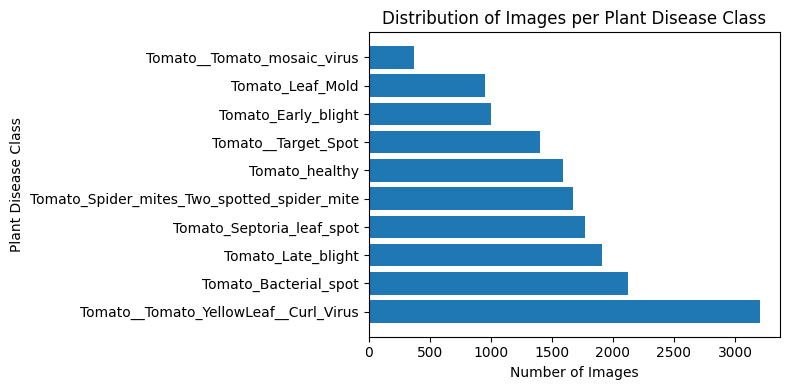

In [6]:
files_per_folder_counts(output_dir)

In [7]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)
    #print(f"Displaying images from class: {classname}")

    # Plot them
    plt.figure(figsize=(5, 5))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

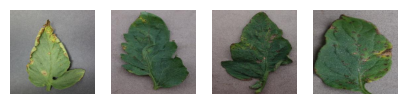

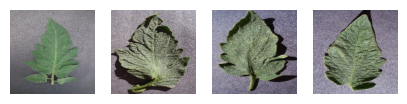

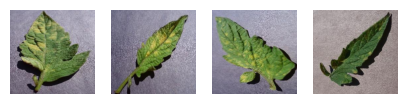

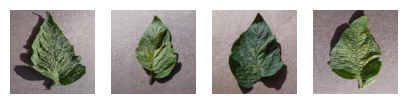

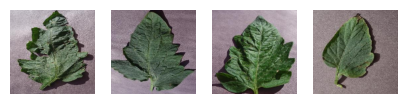

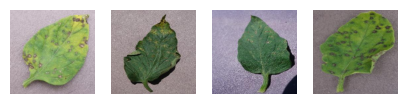

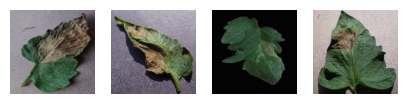

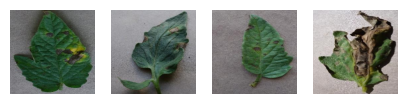

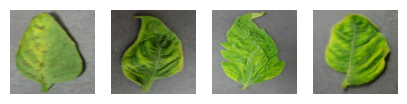

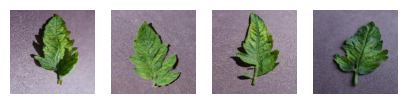

In [8]:
for name in classes:
    sample_images(output_dir, name)

# Data Transformation and Preparaton

In [9]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [10]:
def get_mean_std(loader):

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [11]:
#  Define Paths ---
# The source directory containing all the class folders
source_data_dir = "/kaggle/working/tomatodata" 

# The new base directory for our split dataset
output_dir = "/kaggle/working/tomato_split_dataset"

# Define paths for train, validation, and test sets
train_val_dir = os.path.join(output_dir, 'train_val') # Temporary holder for train+val
test_dir = os.path.join(output_dir, 'test')

In [12]:
#  Create Test Set and Separate Remaining Data ---

# Clean up previous runs if they exist
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create the directories
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [13]:
# Iterate over each class in the source directory
for class_name in os.listdir(source_data_dir):
    class_src_path = os.path.join(source_data_dir, class_name)
    
    # Skip files, process only directories
    if not os.path.isdir(class_src_path):
        continue

    # Create corresponding class folders in train_val and test directories
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image files for the class
    images = os.listdir(class_src_path)
    random.shuffle(images) # Shuffle to get random samples

    # Select 5 images for the test set
    test_images = images[:5]
    # The rest are for training and validation
    train_val_images = images[5:]

    # Copy files to their new destinations
    for img in test_images:
        shutil.copy(os.path.join(class_src_path, img), os.path.join(test_dir, class_name, img))
    
    for img in train_val_images:
        shutil.copy(os.path.join(class_src_path, img), os.path.join(train_val_dir, class_name, img))

print(" Test set created successfully.")

 Test set created successfully.


In [14]:
def class_counts(dataset): # for train and val
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [15]:
# --- 1. Define Your Paths ---
# This is the folder containing your imbalanced training and validation images combined
source_train_val_dir = "/kaggle/working/tomato_split_dataset/train_val"

# This is where the new, balanced dataset will be created
balanced_dataset_dir = "/kaggle/working/tomato_split_dataset/balanced_train_val_data"

In [16]:
def balance_dataset(source_dir, output_dir, target_count=None):
    """
    Balances an image dataset by oversampling under-represented classes 
    and undersampling over-represented classes.

    Oversampling is done by applying random data augmentations.
    Undersampling is done by randomly selecting a subset of images.

    Args:
        source_dir (str): The path to the source directory. It should contain 
                          subdirectories for each class.
        output_dir (str): The path to the directory where the balanced dataset 
                          will be saved.
        target_count (int, optional): The desired number of images for each class.
                                     If None, it defaults to the count of the 
                                     largest class in the source directory.
    """
    # --- 1. Initial Setup and Validation ---
    
    # Ensure the source directory exists
    if not os.path.isdir(source_dir):
        raise ValueError(f"Source directory not found at {source_dir}")

    # Clean up and create the output directory to ensure a fresh start
    if os.path.exists(output_dir):
        print(f"Removing existing directory: {output_dir}")
        shutil.rmtree(output_dir)
    print(f"Creating new directory: {output_dir}")
    os.makedirs(output_dir)

    # --- 2. Calculate Class Distribution and Determine Target Count ---
    
    class_counts = {}
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    
    if not class_counts:
        print("No class directories found in the source directory.")
        return

    # Determine the target count for each class
    if target_count is None:
        target_count = max(class_counts.values())
        print(f"Target count not provided. Defaulting to the largest class size: {target_count}")
    else:
        print(f"Target count set to: {target_count}")

    # --- 3. Define Data Augmentation Pipeline for Oversampling ---
    
    # These transformations will be applied randomly to create new images
    augmentation_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # Add other transforms like random crop or zoom if desired
    ])

    # --- 4. Process Each Class ---
    
    # Use tqdm for a nice progress bar
    for class_name, current_count in tqdm(class_counts.items(), desc="Balancing classes"):
        source_class_path = os.path.join(source_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)
        
        original_images = os.listdir(source_class_path)
        original_image_paths = [os.path.join(source_class_path, img) for img in original_images]

        # --- Undersampling Logic ---
        if current_count > target_count:
            # Randomly select 'target_count' images to keep
            images_to_copy = random.sample(original_image_paths, target_count)
            for img_path in images_to_copy:
                shutil.copy(img_path, output_class_path)

        # --- Oversampling Logic ---
        elif current_count < target_count:
            # First, copy all original images
            for img_path in original_image_paths:
                shutil.copy(img_path, output_class_path)
            
            # Calculate how many new images need to be generated
            num_to_generate = target_count - current_count
            
            for i in range(num_to_generate):
                # Randomly pick an original image to augment
                random_img_path = random.choice(original_image_paths)
                
                # Open the image
                img = PIL.Image.open(random_img_path).convert("RGB")
                
                # Apply the augmentation
                augmented_img = augmentation_transforms(img)
                
                # Create a new unique filename for the augmented image
                base_name, ext = os.path.splitext(os.path.basename(random_img_path))
                new_filename = f"{base_name}_aug_{i}{ext}"
                save_path = os.path.join(output_class_path, new_filename)
                
                # Save the new image
                augmented_img.save(save_path)
        
        # --- No Change Needed ---
        else: # current_count == target_count
            # Just copy all original images
            for img_path in original_image_paths:
                shutil.copy(img_path, output_class_path)

    print("\n Dataset balancing complete!")

In [17]:
def plot_class_distribution(directory, title):
    """Helper function to plot the distribution of images per class."""
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    
    df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
    df_counts = df_counts.sort_values(by='count')
    
    plt.figure(figsize=(10, 6))
    plt.barh(df_counts.index, df_counts['count'])
    plt.xlabel("Number of Images")
    plt.ylabel("Class")
    plt.title(title)
    plt.tight_layout()
    plt.show()

--- Distribution Before Balancing ---


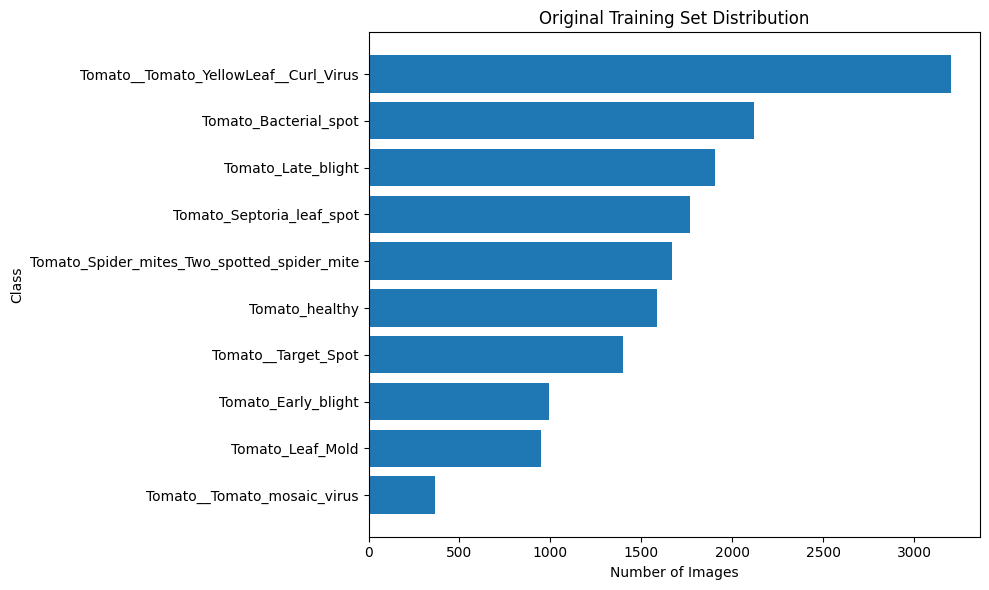

Creating new directory: /kaggle/working/tomato_split_dataset/balanced_train_val_data
Target count set to: 1500


Balancing classes:   0%|          | 0/10 [00:00<?, ?it/s]


 Dataset balancing complete!

--- Distribution After Balancing ---


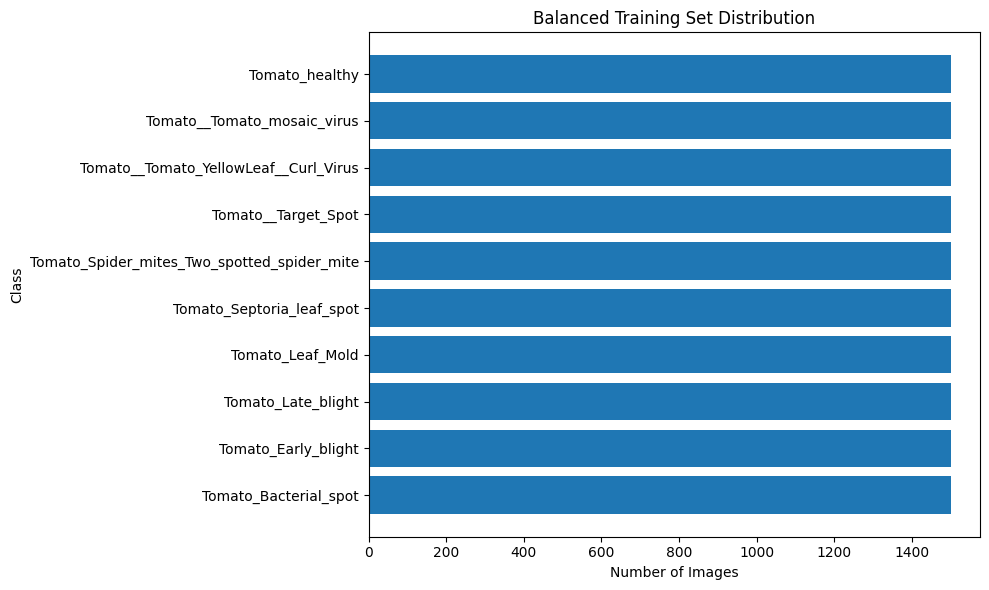

In [18]:
if os.path.isdir(source_train_val_dir):
    # Visualize the distribution before balancing
    print("--- Distribution Before Balancing ---")
    plot_class_distribution(source_train_val_dir, "Original Training Set Distribution")

    # Run the balancing function
    # The target_count will automatically be set to the size of the largest class if no target is given
    # Else it will treat the given target
    balance_dataset(source_train_val_dir, balanced_dataset_dir, 1500)

    # Visualize the distribution after balancing
    print("\n--- Distribution After Balancing ---")
    plot_class_distribution(balanced_dataset_dir, "Balanced Training Set Distribution")
else:
    print(f"Example Usage Skipped: Source directory '{source_train_val_dir}' not found.")
    print("Please update the 'source_train_dir' variable to your dataset's path.")

In [19]:
batch_size = 32
basic_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)), # Good practice to ensure all images are the same size
    transforms.ToTensor()
])

In [20]:
# Load the entire balanced dataset
balanced_dataset = datasets.ImageFolder(root=balanced_dataset_dir, transform = basic_transform)
balanced_dataset_loader = DataLoader(balanced_dataset, batch_size = batch_size)
batch_shape = next(iter(balanced_dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)
print(f"\nTotal images for training and validation: {len(balanced_dataset)}")

# Set a seed for reproducibility
g = torch.Generator()
g.manual_seed(42)

# Split it 80/20
balanced_train_dataset, balanced_val_dataset = random_split(balanced_dataset, [0.8, 0.2],generator=g)

Getting batches of shape: torch.Size([32, 3, 224, 224])

Total images for training and validation: 15000


In [21]:
# - Verify the Split ---
length_train = len(balanced_train_dataset)
length_val = len(balanced_val_dataset)
length_test = sum([len(files) for r, d, files in os.walk(test_dir)])

print(f"Training samples: {length_train}")
print(f"Validation samples: {length_val}")
print(f"Test samples: {length_test}")

Training samples: 12000
Validation samples: 3000
Test samples: 50


In [22]:
#  Calculate Mean and Std (CORRECT PLACEMENT) ---
print(" Calculating normalization stats from TRAINING data only ---")


mean, std = get_mean_std(DataLoader(balanced_train_dataset, batch_size=32))
print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}\n")

 Calculating normalization stats from TRAINING data only ---


Computing mean and std:   0%|          | 0/375 [00:00<?, ?it/s]

Calculated Mean: tensor([0.4487, 0.4594, 0.4147])
Calculated Std: tensor([0.1846, 0.1623, 0.1977])



In [23]:
#Create Final DataLoaders with Normalization ---
print(" Creating final DataLoaders with normalization ---")
# Now, define the final transform WITH the correct normalization stats
final_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Apply the final transform to both train and validation datasets
balanced_train_dataset.dataset.transform = final_transform
# The validation set shares the same underlying dataset, so its transform is also updated.

# Create the final DataLoaders
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
balanced_val_loader = DataLoader(balanced_val_dataset, batch_size=32, shuffle=False)
print(" Final DataLoaders are ready.\n")

 Creating final DataLoaders with normalization ---
 Final DataLoaders are ready.



  0%|          | 0/12000 [00:00<?, ?it/s]

<Axes: >

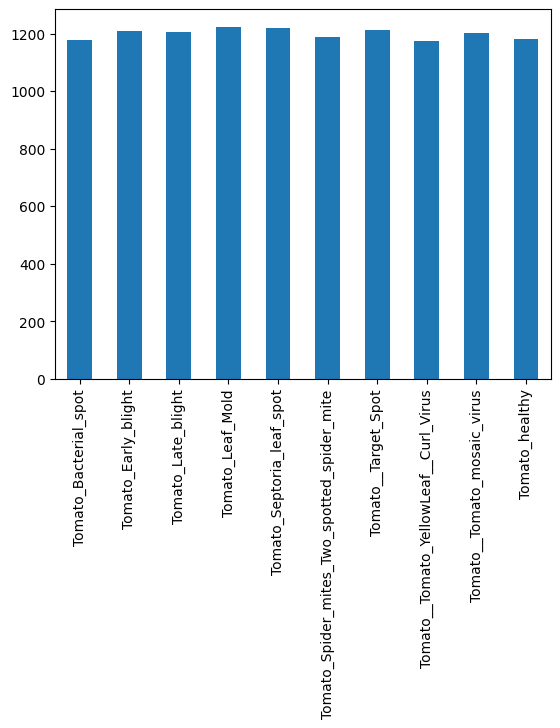

In [24]:
b_t_counts = class_counts(balanced_train_dataset)
b_t_counts.plot(kind ="bar")

  0%|          | 0/3000 [00:00<?, ?it/s]

<Axes: >

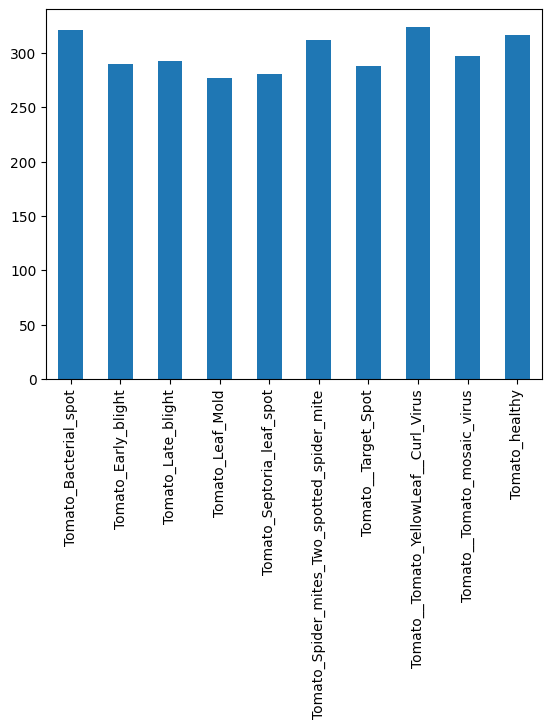

In [25]:
b_val_counts = class_counts(balanced_val_dataset)
b_val_counts.plot(kind ="bar")

In [26]:
# Final Cleanup ---
print("Cleaning up intermediate folders ---")
folders_to_remove = [
    "/kaggle/working/tomatodata",
    "/kaggle/working/tomato_split_dataset/train_val"
]
for folder in folders_to_remove:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Removed: {folder}")
print("\n Cleanup complete. Ready to commit.")

Cleaning up intermediate folders ---
Removed: /kaggle/working/tomatodata
Removed: /kaggle/working/tomato_split_dataset/train_val

 Cleanup complete. Ready to commit.


# Model Training

In [27]:
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib
from tqdm import tqdm

In [28]:
# Loading RESNET50 Model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
for params in model.parameters():
    params.requires_grad = False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
in_feat = model.fc.in_features

print(in_feat)

2048


In [31]:
modified_last_layer = nn.Sequential()

modified_last_layer.append(nn.Linear(in_feat, 256))

relu = nn.ReLU()
modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

linear = nn.Linear(256,10)
modified_last_layer.append(linear)

model.fc = modified_last_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [33]:
import torch
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [34]:
# Place model on device
model.to(device)

print(next(model.parameters()).device)

cuda:0


In [35]:
height = 224
width = 224

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [36]:
# Period of learning rate decay
step_size = 4
# Multiplicative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [37]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter >= 5:
        stop = True
    return counter, stop

early_stopping?

Signature: early_stopping(validation_loss, best_val_loss, counter)
Docstring: Function that implements Early Stopping
File:      /tmp/ipykernel_36/4127618178.py
Type:      function


In [38]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

In [39]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)

In [40]:
def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    # Corrected the calculation for the number of observations
    n_observations = len(data_loader.dataset)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

In [41]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
    model_evaluation_metrics=None, # Added to accept the dictionary
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

        #Saving the training metric if a dictionary is provided
        if model_evaluation_metrics is not None:
            model_evaluation_metrics[epoch] = {
            "train_losses": train_loss,
            "val_losses": validation_loss,
            "val_accuracies": validation_accuracy,
            "train_accuracies": train_accuracy,
            "learning_rates": lr
            }
    
    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [42]:
os.makedirs("model", exist_ok=True)

In [43]:
epochs_to_train = 50

# Initialize dictionary to store metrics
model_evaluation_metrics = {}

train_results = train(
    model,
    optimizer,
    loss_fn,
    balanced_train_loader,  # Train variable name
    balanced_val_loader,    # Val variable name
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",
    early_stopping=early_stopping,
    model_evaluation_metrics=model_evaluation_metrics, # Pass the dictionary
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...




Starting epoch 1/50


Epoch: 1
Training loss: 0.2901
Training accuracy: 92.5500%
Validation loss: 0.3195
Validation accuracy: 90.9333%
Checkpoint saved with validation loss 0.3195


Starting epoch 2/50


Epoch: 2
Training loss: 0.1791
Training accuracy: 94.8500%
Validation loss: 0.2362
Validation accuracy: 93.0000%
Checkpoint saved with validation loss 0.2362


Starting epoch 3/50


Epoch: 3
Training loss: 0.1160
Training accuracy: 96.8417%
Validation loss: 0.1897
Validation accuracy: 93.6000%
Checkpoint saved with validation loss 0.1897


Starting epoch 4/50


Epoch: 4
Training loss: 0.0899
Training accuracy: 97.5750%
Validation loss: 0.1724
Validation accuracy: 94.1333%
Checkpoint saved with validation loss 0.1724


Starting epoch 5/50


Epoch: 5
Training loss: 0.0639
Training accuracy: 98.5917%
Validation loss: 0.1434
Validation accuracy: 95.3667%
Checkpoint saved with validation loss 0.1434


Starting epoch 6/50


Epoch: 6
Training loss: 0.0590
Training accuracy: 98.8167%
Validation loss: 0.1426
Validation accuracy: 95.4000%
Checkpoint saved with validation loss 0.1426


Starting epoch 7/50


Epoch: 7
Training loss: 0.0520
Training accuracy: 98.9250%
Validation loss: 0.1381
Validation accuracy: 95.3000%
Checkpoint saved with validation loss 0.1381


Starting epoch 8/50


Epoch: 8
Training loss: 0.0520
Training accuracy: 98.9167%
Validation loss: 0.1375
Validation accuracy: 95.3333%
Checkpoint saved with validation loss 0.1375


Starting epoch 9/50


Epoch: 9
Training loss: 0.0470
Training accuracy: 98.9750%
Validation loss: 0.1327
Validation accuracy: 95.6000%
Checkpoint saved with validation loss 0.1327


Starting epoch 10/50


Epoch: 10
Training loss: 0.0502
Training accuracy: 98.9083%
Validation loss: 0.1370
Validation accuracy: 95.4667%


Starting epoch 11/50


Epoch: 11
Training loss: 0.0454
Training accuracy: 99.1417%
Validation loss: 0.1297
Validation accuracy: 95.7667%
Checkpoint saved with validation loss 0.1297


Starting epoch 12/50


Epoch: 12
Training loss: 0.0461
Training accuracy: 99.0667%
Validation loss: 0.1363
Validation accuracy: 95.3667%


Starting epoch 13/50


Epoch: 13
Training loss: 0.0424
Training accuracy: 99.1750%
Validation loss: 0.1314
Validation accuracy: 95.4667%


Starting epoch 14/50


Epoch: 14
Training loss: 0.0435
Training accuracy: 99.1583%
Validation loss: 0.1322
Validation accuracy: 95.8000%


Starting epoch 15/50


Epoch: 15
Training loss: 0.0454
Training accuracy: 99.1917%
Validation loss: 0.1342
Validation accuracy: 95.7333%


Starting epoch 16/50


Epoch: 16
Training loss: 0.0437
Training accuracy: 99.1917%
Validation loss: 0.1336
Validation accuracy: 95.5000%
Early stopping triggered after 16 epochs


In [45]:
print(f"Training went on for {epochs} number of epochs before it stopped.")

Training went on for 16 number of epochs before it stopped.


In [46]:
#save the model in model directory as name "tomato_prediction"
torch.save(model.state_dict(), "model/tomato_prediction_model.pth")
print("Final model state_dict saved to model/tomato_prediction_model.pth")

Final model state_dict saved to model/tomato_prediction_model.pth


In [48]:
# Save the metrics to a CSV file
eval_metrics_df = pd.DataFrame(model_evaluation_metrics).transpose()
eval_metrics_df.to_csv("model/model_evaluation_metrics.csv", index_label="epoch")
print("Training metrics saved to model/model_evaluation_metrics.csv")

# Now, read it back to populate the variables for plotting
eval_metrics_df = pd.read_csv("model/model_evaluation_metrics.csv")
train_losses = eval_metrics_df['train_losses'].values
valid_losses = eval_metrics_df['val_losses'].values
train_accuracies = eval_metrics_df['train_accuracies'].values
valid_accuracies = eval_metrics_df['val_accuracies'].values
learning_rates = eval_metrics_df['learning_rates'].dropna().values

Training metrics saved to model/model_evaluation_metrics.csv


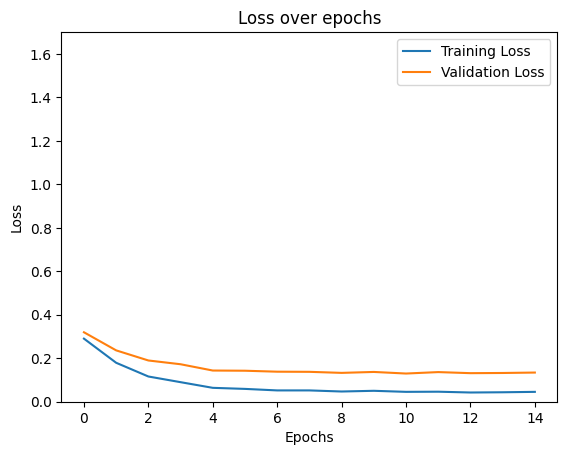

In [49]:
# Plot train losses
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

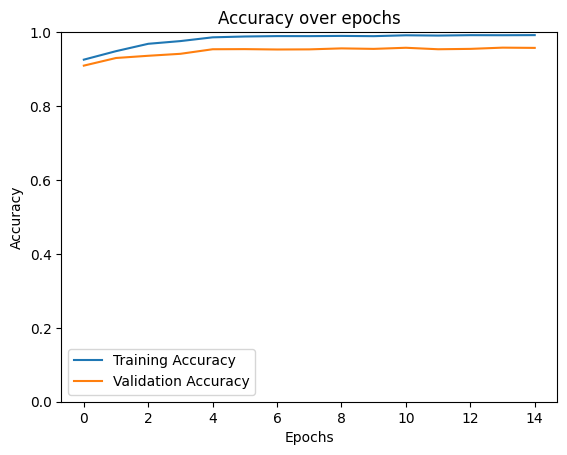

In [50]:
# Plot train accuracies, use label="Training Accuracy"
plt.plot(train_accuracies, label = "Training Accuracy")
# Plot validation accuracies, use label="Validation Accuracy"
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

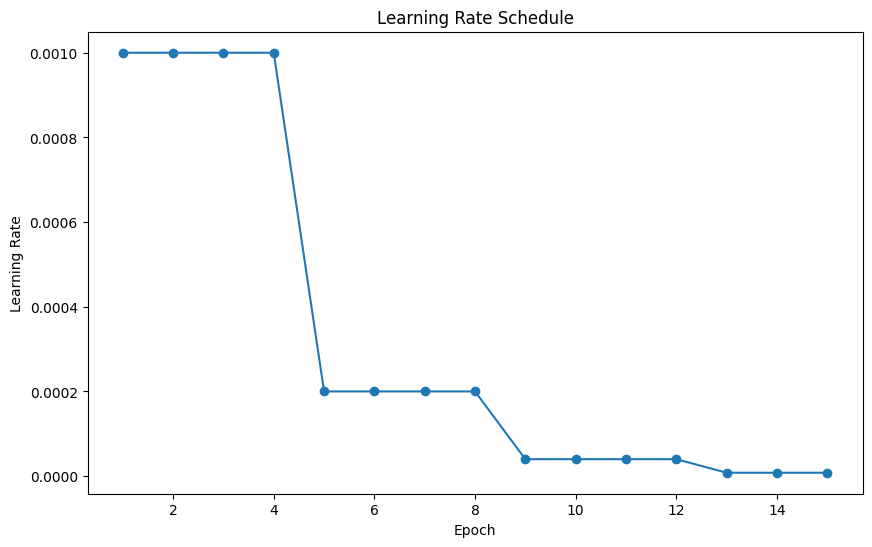

In [61]:
# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [52]:
checkpoint = torch.load("model/LR_model.pth")

# Load the state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [53]:
def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [54]:
# make test loader for final testing
test_dataset = datasets.ImageFolder(root=test_dir, transform=final_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Test dataset loaded with {len(test_dataset)} images.")

Test dataset loaded with 50 images.


In [55]:
# Get final accuracy score on the test set
test_loss, test_accuracy = score(model, test_loader, loss_fn, device=device)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")


Final Test Loss: 0.0846
Final Test Accuracy: 98.00%


In [56]:
probabilities_val = predict(model, test_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

tensor([0, 0, 0, 0, 0, 1, 1, 6, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')


Get Labels: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s]


<Figure size 1000x800 with 0 Axes>

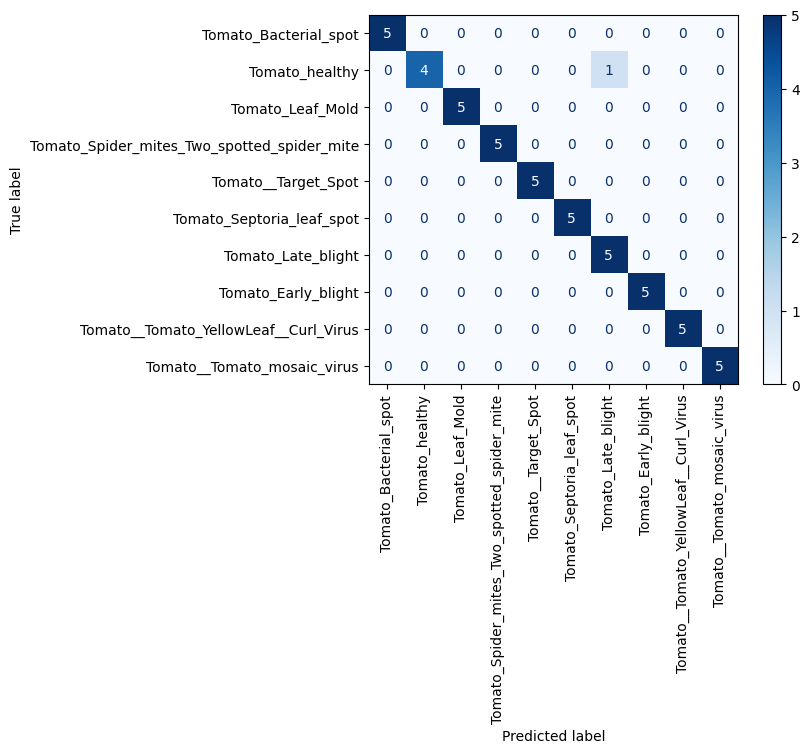

In [57]:
targets_val = torch.cat([labels for _, labels in tqdm(test_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [63]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [64]:
# Calculate Accuracy and the Classification Report
targets_cpu = targets_val.cpu().numpy()
predictions_cpu = predictions_val.cpu().numpy()
probabilities_cpu = probabilities_val.cpu().numpy()

accuracy = accuracy_score(targets_cpu, predictions_cpu)
print(f"Overall Accuracy: {accuracy * 100:.2f}%\n")

print("--- Classification Report ---")
report = classification_report(targets_cpu, predictions_cpu, target_names=classes)
print(report)

Overall Accuracy: 98.00%

--- Classification Report ---
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       1.00      1.00      1.00         5
                             Tomato_healthy       1.00      0.80      0.89         5
                           Tomato_Leaf_Mold       1.00      1.00      1.00         5
Tomato_Spider_mites_Two_spotted_spider_mite       1.00      1.00      1.00         5
                        Tomato__Target_Spot       1.00      1.00      1.00         5
                  Tomato_Septoria_leaf_spot       1.00      1.00      1.00         5
                         Tomato_Late_blight       0.83      1.00      0.91         5
                        Tomato_Early_blight       1.00      1.00      1.00         5
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00         5
                Tomato__Tomato_mosaic_virus       1.00      1.00      1.00         5

       


ROC curve plot has been generated and saved as 'roc_curves.png'.


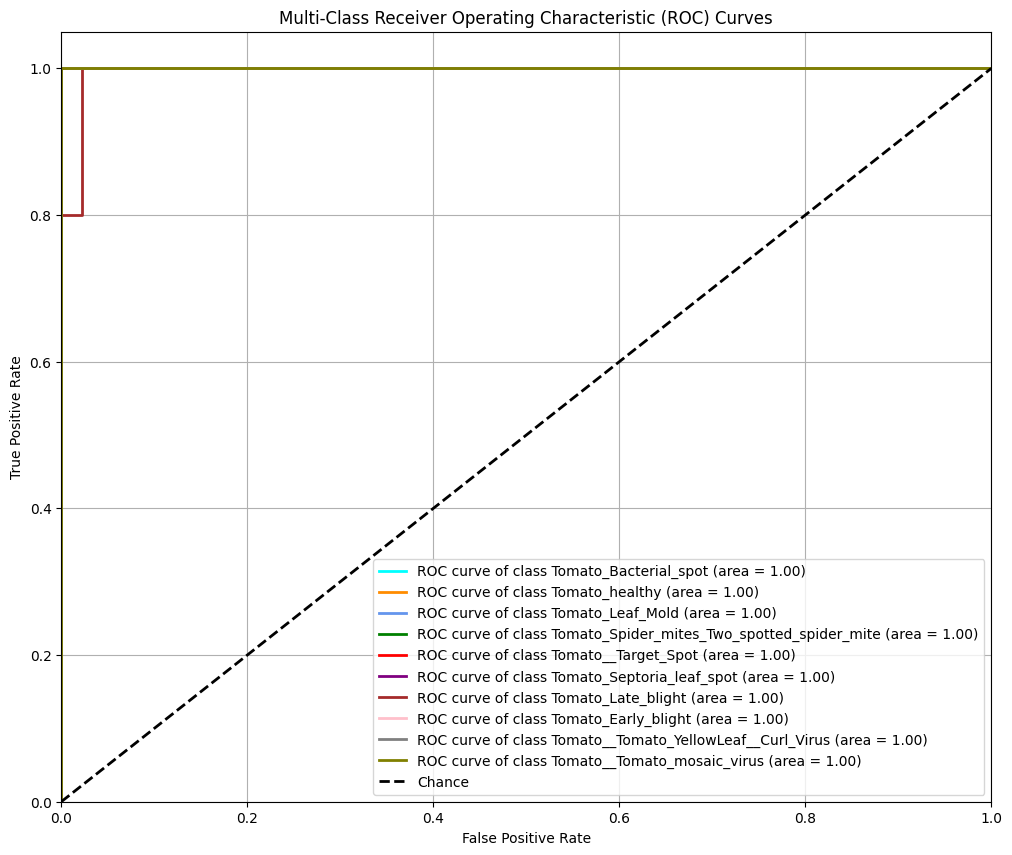

In [65]:
# Calculate and Plot Multi-Class ROC Curve
y_test_binarized = label_binarize(targets_cpu, classes=np.arange(len(classes)))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities_cpu[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curves.png')
print("\nROC curve plot has been generated and saved as 'roc_curves.png'.")

In [58]:
def file_to_confidence(model, file_path, transform_pipeline, device="cpu"):
    """Helper function to get model prediction for a single image file."""
    image = PIL.Image.open(file_path)
    transformed = transform_pipeline(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)
    
    # Get the class names from the dataset object used for training
    class_names = balanced_dataset.classes
    conf_df = pd.DataFrame([[os.path.basename(file_path)] + confidence.tolist()[0]])
    conf_df.columns = ["ID"] + class_names

    return conf_df

In [59]:
# Corrected loop to iterate through subdirectories
small_dfs = []
test_image_dir = "/kaggle/working/tomato_split_dataset/test"

for class_folder in tqdm(os.listdir(test_image_dir), desc="Predicting on test set"):
    class_path = os.path.join(test_image_dir, class_folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            small_dfs.append(
                file_to_confidence(model, file_path, final_transform, device)
            )

confidence_df = pd.concat(small_dfs)
confidence_df = confidence_df.sort_values("ID").reset_index(drop=True)
confidence_df.head()

Predicting on test set: 100%|██████████| 10/10 [00:00<00:00, 14.22it/s]


,ID,Tomato_Bacterial_spot,Tomato_Early_blight,Tomato_Late_blight,Tomato_Leaf_Mold,Tomato_Septoria_leaf_spot,Tomato_Spider_mites_Two_spotted_spider_mite,Tomato__Target_Spot,Tomato__Tomato_YellowLeaf__Curl_Virus,Tomato__Tomato_mosaic_virus,Tomato_healthy
0,006e354b-c054-4b72-a83c-e3feb038942e___PSU_CG ...,0.003164,0.051304,0.000822,0.000100,1.252034e-02,8.036848e-03,3.574127e-02,0.001595,8.865153e-01,2.000406e-04
1,05777829-6912-44bb-bcef-901bc5190584___GCREC_B...,0.975864,0.022994,0.000097,0.000001,9.749422e-04,3.953092e-07,6.444308e-05,0.000004,3.604097e-08,1.552097e-08
2,0a167675-0317-4105-b885-b707b6ea52cf___Com.G_S...,0.000003,0.000195,0.000075,0.000308,9.958941e-05,9.857393e-01,2.739983e-03,0.001561,9.171108e-03,1.067910e-04
3,0c7b6caf-1be3-4061-87a0-28946c7aa3d2___YLCV_GC...,0.000147,0.002430,0.000004,0.000008,9.372324e-08,6.699031e-06,2.198200e-07,0.997402,1.202737e-06,8.544150e-12
4,0ec3e86a-8c2a-4f66-9c29-ee995dc88a7e___UF.GRC_...,0.000099,0.000004,0.000067,0.000024,6.516713e-07,2.480588e-05,3.948180e-06,0.999776,1.016172e-07,7.101453e-08


In [60]:
#save the submission.csv on model directory
submission_path = "model/submission.csv"
confidence_df.to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")

Submission file saved to model/submission.csv
